# Emulation of Weather Types

## Weather Typing + Linear Model (categorical)
## Predictand- Load Weather Types (categorical data)
## (yes! large scale predictor of the regional/local predictand)

In [1]:
from bluemath_tk.core.io import load_model

dwt = load_model("outputs/dwt_model_aveiro.pkl")
dwt

In [2]:
dwt_kma_bmus_df = dwt.kma_bmus.copy()
dwt_kma_bmus_df.index.name = "time"
dwt_kma_bmus_df.columns = ["bmus"]
dwt_kma_bmus_ds = dwt_kma_bmus_df.to_xarray()
dwt_kma_bmus_ds

<xarray.Dataset> Size: 236kB
Dimensions:  (time: 19684)
Coordinates:
  * time     (time) datetime64[s] 157kB 1970-01-01 1970-01-02 ... 2023-11-22
Data variables:
    bmus     (time) int32 79kB 15 15 15 10 10 10 10 10 ... 6 7 16 15 15 6 24 24

## Predictor- load Far Field covariates

In [3]:
awt = load_model("outputs/awt_model_aveiro.pkl")
covariates_ds = (
    awt.steps.get("pca")
    .pcs.resample(time="1D")
    .pad()
    .rename({"n_component": "n_covariates", "PCs": "cov_norm"})
    .drop(["stds", "kma_bmus"])
)
covariates_ds = (covariates_ds - covariates_ds.mean(dim="time")) / covariates_ds.std(
    dim="time"
)
covariates_ds["cov_names"] = (("n_covariates"), [f"PC{i}" for i in range(1, 4)])
covariates_ds

<xarray.Dataset> Size: 620kB
Dimensions:       (time: 19359, n_covariates: 3)
Coordinates:
  * time          (time) datetime64[ns] 155kB 1970-01-01 ... 2023-01-01
  * n_covariates  (n_covariates) int64 24B 0 1 2
Data variables:
    cov_norm      (time, n_covariates) float64 465kB -1.195 0.1036 ... 0.9812
    cov_names     (n_covariates) <U3 36B 'PC1' 'PC2' 'PC3'

## Predictand to Predictor - Model
### Autoregressive Multinomial Logistic Regression

In [ ]:
from bluemath_tk.teslakit.alr import ALR_WRP

alr_terms = {
    "mk_order": 3,
    "constant": True,
    "long_term": False,
    "seasonality": (True, [2, 4, 6]),
    "covariates": (
        True,
        covariates_ds.sel(time=dwt_kma_bmus_ds.time, method="nearest"),
    ),
}

alr_model = ALR_WRP(
    p_base="/workspaces/BlueMath/climate_services/probabilistic/MUSCLE_Aveiro/outputs/dwt_alr"
)
alr_model.SetFitData(
    cluster_size=dwt.num_clusters,
    xds_bmus_fit=dwt_kma_bmus_ds,
    d_terms_settings=alr_terms,
)
alr_model.FitModel(max_iter=1000)


Fitting autoregressive logistic model ...
Optimization done in 135.35 seconds



/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


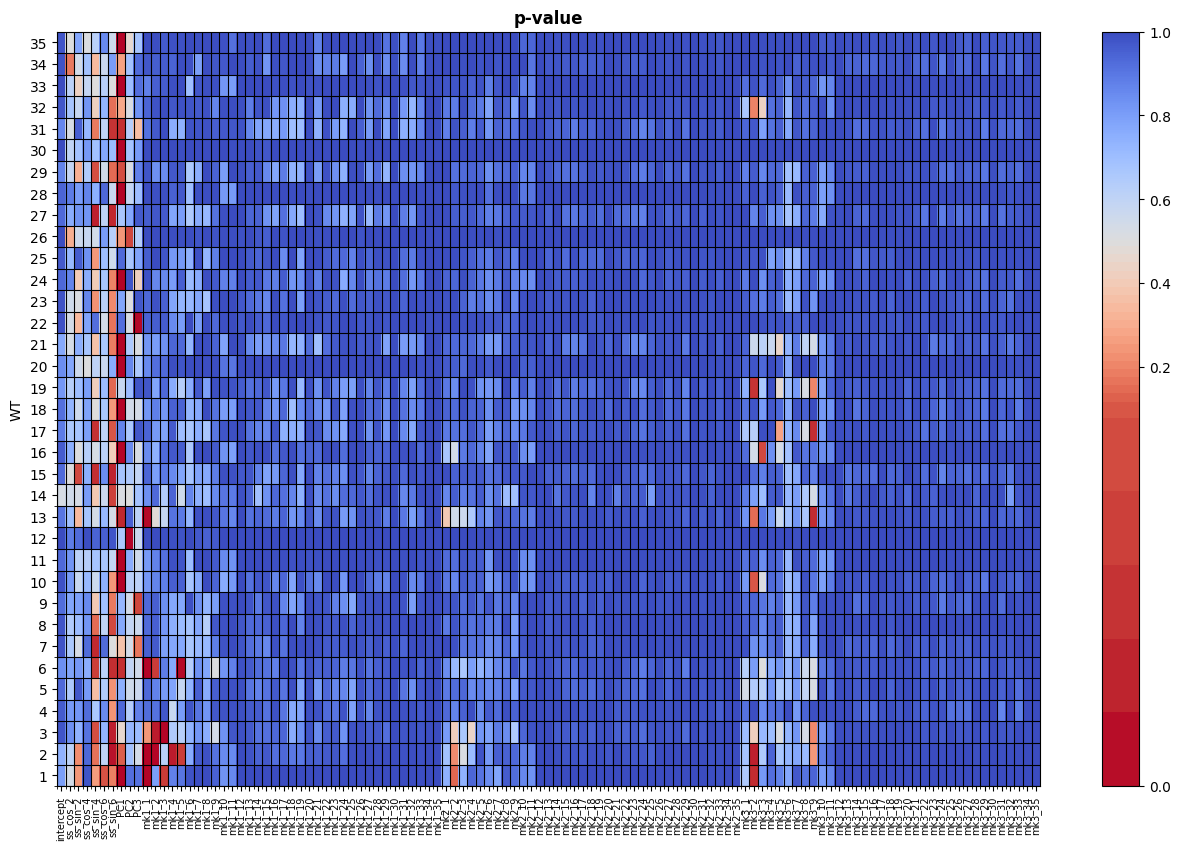

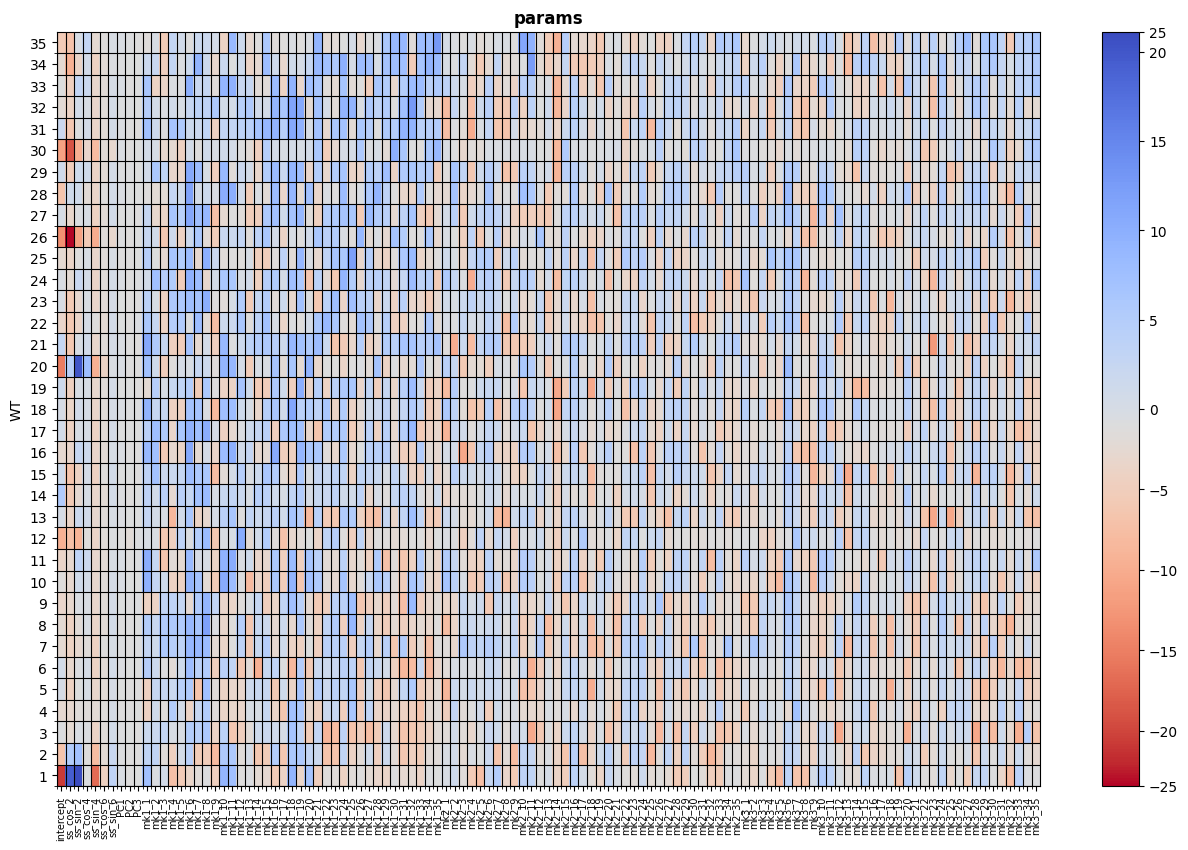

In [5]:
# Plot model p-values and params

alr_model.Report_Fit()

## Emulation of Weather Types
### Load covariates

In [6]:
import xarray as xr

simulated_annual_PCs = (
    xr.open_dataset("outputs/simulated_PCs.nc").resample(time="1D").pad()
)
simulated_annual_PCs

<xarray.Dataset> Size: 89MB
Dimensions:     (time: 36891, n_sim: 100, n_covariates: 3)
Coordinates:
  * time        (time) datetime64[ns] 295kB 1999-01-01 1999-01-02 ... 2100-01-01
  * n_sim       (n_sim) int64 800B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
Dimensions without coordinates: n_covariates
Data variables:
    cov_values  (n_sim, time, n_covariates) float64 89MB ...

## Emulation- simulation and ensembling

In [7]:
# --------------------------------------
# Autoregressive Logistic Regression - simulate

# launch simulation
simulated_daily_bmus = alr_model.Simulate(
    num_sims=5,
    time_sim=simulated_annual_PCs.time.values,
    xds_covars_sim=simulated_annual_PCs,
)
simulated_daily_bmus

ALR model fit   : 1970-01-01 --- 2023-11-22
ALR model sim   : 1999-01-01 --- 2100-01-01

Launching 5 simulations...

Sim. Num. 005 (Covs. 005): 100%|██████████| 36888/36888 [00:27<00:00, 1352.35it/s]



<xarray.Dataset> Size: 2MB
Dimensions:      (time: 36891, n_sim: 5)
Coordinates:
  * time         (time) datetime64[ns] 295kB 1999-01-01 ... 2100-01-01
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) int64 1MB 15 15 15 15 15 15 ... 5 17 26 25 34 5
    ofbmus_sims  (time, n_sim) bool 184kB False False False ... False False

In [8]:
simulated_daily_bmus.to_netcdf("outputs/xds_output.nc")

## Emulation- Assesing ALR model

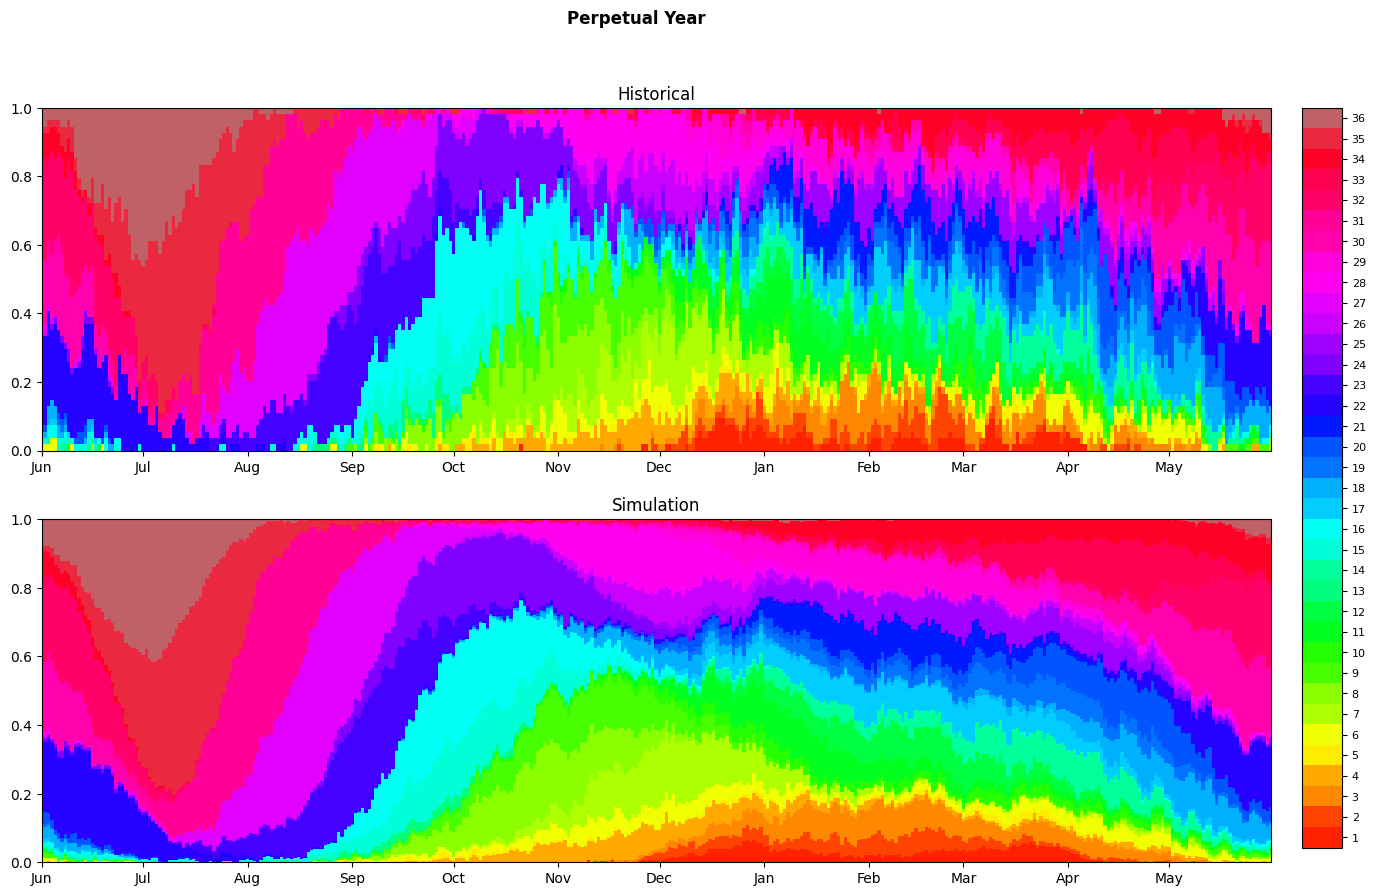

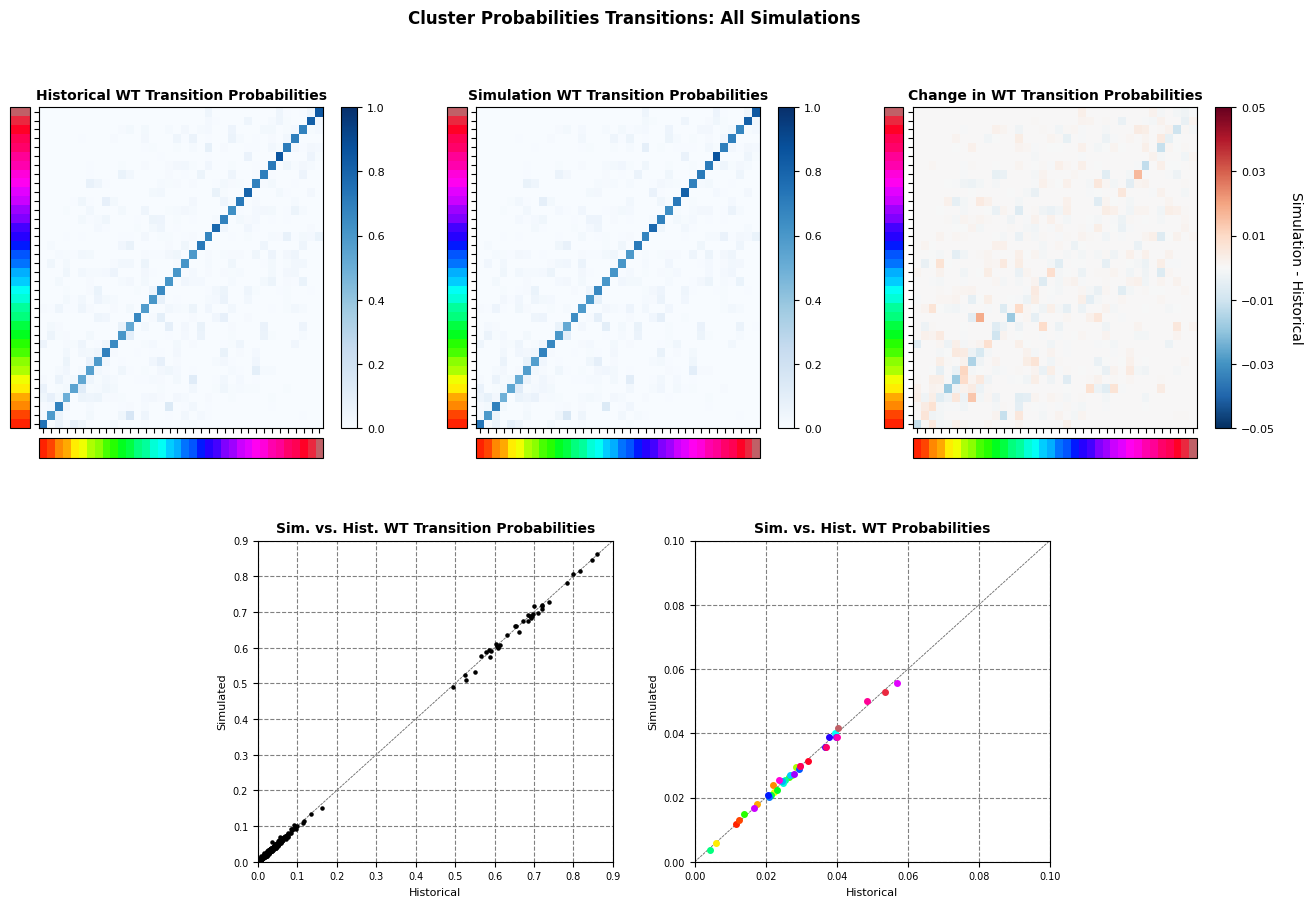

In [9]:
# show sim report

_fig = alr_model.Report_Sim(py_month_ini=6)